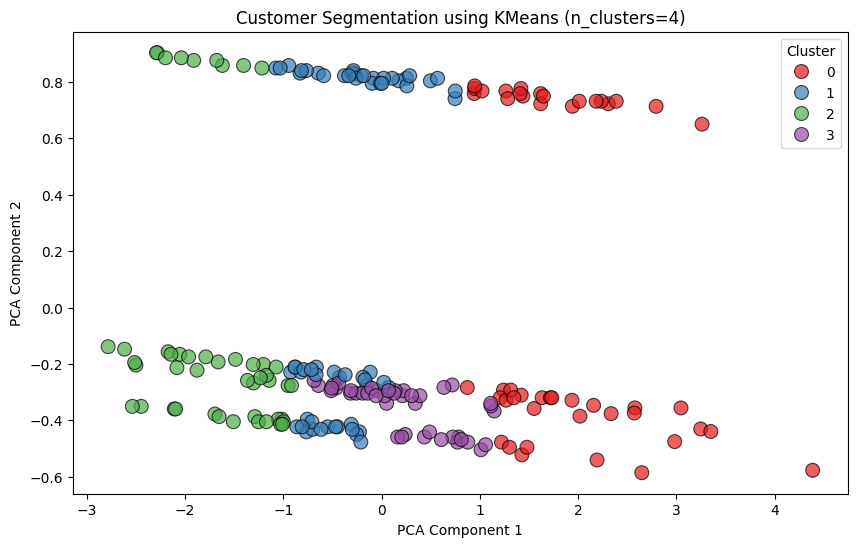

Number of Clusters: 4
Davies-Bouldin Index (DBI): 1.5243


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# 1. Data Preprocessing

# Group the transactions by CustomerID and aggregate the necessary metrics
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'Quantity': 'sum',  # total quantity purchased
    'TotalValue': 'sum',  # total spend
}).reset_index()

# Merge with customer profile data (Region, etc.)
customer_profile = pd.merge(customers_df[['CustomerID', 'Region']], customer_transactions, on='CustomerID', how='left')

# 2. Feature Engineering
# Encode 'Region' using one-hot encoding
region_dummies = pd.get_dummies(customer_profile['Region'], prefix='Region')

# Combine profile features with transaction data
features_df = pd.concat([customer_profile[['CustomerID', 'Quantity', 'TotalValue']], region_dummies], axis=1)

# Handle missing values (fill with 0)
features_df = features_df.fillna(0)

# Scale the numerical features
scaler = StandardScaler()
features_df[['Quantity', 'TotalValue']] = scaler.fit_transform(features_df[['Quantity', 'TotalValue']])

# 3. Clustering (using K-Means)
# Set number of clusters between 2 and 10 (let's start with 4 clusters)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(features_df.drop(columns=['CustomerID']))

# 4. Evaluate Clustering Metrics
dbi = davies_bouldin_score(features_df.drop(columns=['CustomerID', 'Cluster']), features_df['Cluster'])

# 5. Visualize Clusters (Using PCA for dimensionality reduction)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_df.drop(columns=['CustomerID', 'Cluster']))

# Create a DataFrame for PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = features_df['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='Set1', data=pca_df, s=100, alpha=0.7, edgecolor='black')
plt.title(f'Customer Segmentation using KMeans (n_clusters={n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 6. Clustering Report
print(f'Number of Clusters: {n_clusters}')
print(f'Davies-Bouldin Index (DBI): {dbi:.4f}')
